In [1]:
# Study: Semantic Segmentation For Self-Driving Cars
# Dataset: Lyft Udacity Challenge (https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge)
# Author: Willian Oliveira
# Start: 29/06/2023
# Study Motivation: The purpose of this study is to learn how to identify semantic segmentation of cars, roads, etc...
# Study Status: Done

In [2]:
%load_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision,PIL,matplotlib,albumentations,tqdm --conda

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.13.2

numpy         : 1.24.1
pandas        : 2.0.1
torch         : 2.0.0+cu118
torchvision   : 0.15.1+cu118
PIL           : 9.3.0
matplotlib    : 3.7.1
albumentations: 1.3.1
tqdm          : 4.65.0

conda environment: torch_2.0



In [1]:
# Setup environment and import libraries

import numpy as np
import pandas as pd
import random
import os
import time
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import shutil
from torchsummary import summary
from torch import nn, optim
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(0) # Set seed for reproducibility

START_TIME = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {torch.cuda.get_device_name(DEVICE)}")

Device: NVIDIA GeForce RTX 3060


### Prepare dataset

The original folders and dataset loading functions found on the Kaggle Competition were not splitting the images by scenarios. This might have caused data leakage in the solutions we found there.

To address this issue, we did the following:

1. **Created a function to separate images and masks into Train, Validation, and Test sets by scenario.** This ensures that a scenario is used exclusively for training, validation, or testing, preventing overlap and ensuring distinct datasets for each phase.

2. **Applied normalization to the images.** This step aims to:
   - Reduce potential variabilities on the input.
   - Enhance model performance.
   - Prevent neuron saturation.

Given that we are working with a small number of images, and as we will show in the next section, some classes are disproportionately represented, we decided to merge our validation set with the training set. This allows us to have more data available for training. While data augmentation could be a viable solution, for simplicity, we chose to proceed in this way for this project.


In [ ]:
# Split images to avoid data leakage

# Define origin and destination directories
original_dirs = ["data/data" + i + "/data" + i for i in ["A", "B", "C", "D", "E"]]
train_dir = 'data/train/'
val_dir = 'data/val/'
test_dir = 'data/test/'

# Create destination directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create a list to store the unique scenarios (The first part of the image file name is the scenario ID eg.: '02_00_000.png' the "02" indicates the cenário)
unique_scenarios = []

# Parse through the data directories from dataA to dataE
for source_dir in original_dirs:
    # Parse through the CameraRGB and CameraSeg subfolders
    for camera_folder in ['CameraRGB', 'CameraSeg']:
        folder_path = os.path.join(source_dir, camera_folder)
        for file in os.listdir(folder_path):
            # Extract the scenario ID from the file name
            scenario_id = file.split('_')[0]
            if scenario_id not in unique_scenarios:
                unique_scenarios.append(scenario_id)

# Shuffle the scenarios and split them into train, validation and test sets, in a way that each scenario is only in one set
random.shuffle(unique_scenarios)
train_split = int(len(unique_scenarios)*0.7)  # 70% of the scenarios for training
val_split = train_split + int(len(unique_scenarios)*0.15)  # 15% of the scenarios for validation
train_scenarios = unique_scenarios[:train_split]
val_scenarios = unique_scenarios[train_split:val_split]
test_scenarios = unique_scenarios[val_split:]  # Rest of the scenarios for testing

# Copy the images to the destination folders, following the split approach defined above
for source_dir in original_dirs:
    for camera_folder in ['CameraRGB', 'CameraSeg']:
        folder_path = os.path.join(source_dir, camera_folder)
        for file in os.listdir(folder_path):
            scenario_id = file.split('_')[0]
            source_file_path = os.path.join(folder_path, file)

            if scenario_id in train_scenarios:
                dest_folder = os.path.join(train_dir, camera_folder)
            elif scenario_id in val_scenarios:
                dest_folder = os.path.join(val_dir, camera_folder)
            else:
                dest_folder = os.path.join(test_dir, camera_folder)
                
            os.makedirs(dest_folder, exist_ok=True)
            shutil.copy(source_file_path, os.path.join(dest_folder, file))

In [2]:
# Set the paths to access images and masks

data_dir = ["data/" + i for i in ["test", "val", "train"]]

In [3]:
# Create a custom dataset class for the Lyft Udacity Challenge

class LyftUdacity(Dataset):
    def __init__(self, img_dir, transform = None):
        self.transforms = transform
        image_path = img_dir + '/CameraRGB'
        seg_path = img_dir + '/CameraSeg'
        self.images, self.masks = [], []
        imgs = os.listdir(image_path)
        self.images.extend([image_path+'/'+img for img in imgs])
        masks = os.listdir(seg_path)
        self.masks.extend([seg_path+'/'+mask for mask in masks])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            mask = torch.max(mask,dim=2)[0]
        return img,mask

In [4]:
# Define the transformations to be applied on images and masks

IMG_SIZE = (256, 256)

t1 = A.Compose([
    A.Resize(*IMG_SIZE),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [5]:
# Since there is too few images, we will use the train and validation sets for training and keep the test set as holdout

from torch.utils.data import ConcatDataset

def get_images(data_dir, transform=None, batch_size=1, shuffle=True, pin_memory=True):
    train_data = LyftUdacity(data_dir[2], transform)
    val_data = LyftUdacity(data_dir[1], transform)
    test_data = LyftUdacity(data_dir[0], transform)

    # Concatenating train and val datasets
    train_val_data = ConcatDataset([train_data, val_data])

    train_val_loader = torch.utils.data.DataLoader(train_val_data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_val_loader, test_loader

train_loader, test_loader = get_images(data_dir,transform =t1,batch_size=8)

### Exploratory Data Analysis

In this section, we performed a few validation checks on our data loaders to verify if they were correct. We also printed each label separately to assess if the mask and labels were really matching.

In this second visualization, we could notice that some classes have significantly fewer pixels available per image, such as Traffic Lights, Pedestrians, and Fences. These objects are relatively smaller, which might indicate that we could run into imbalance problems.

We also checked how many images of our datasets the classes were present in to gain further insights into what might affect model performance.

Here's a breakdown of how many images in our datasets each class was present in:

<div align="center">

| Class        | Train | Test |
|--------------|-------|------|
| Unlabeled    | 4449  | 551  |
| Building     | 4009  | 510  |
| Fence        | 4239  | 541  |
| Other        | 4043  | 522  |
| Pedestrian   | 543   | 108  |
| Pole         | 4371  | 546  |
| Roadline     | 4354  | 544  |
| Road         | 4449  | 551  |
| Sidewalk     | 4449  | 551  |
| Vegetation   | 4449  | 551  |
| Car          | 4449  | 551  |
| Wall         | 3427  | 370  |
| Traffic sign | 3625  | 450  |

</div>

From the table, we can observe that classes such as 'Pedestrian' are present in far fewer images compared to other classes like 'Road', 'Car', or 'Sidewalk'. This imbalance in the data may affect the model's performance, as it may become more accurate in identifying classes that are present in a higher number of images.

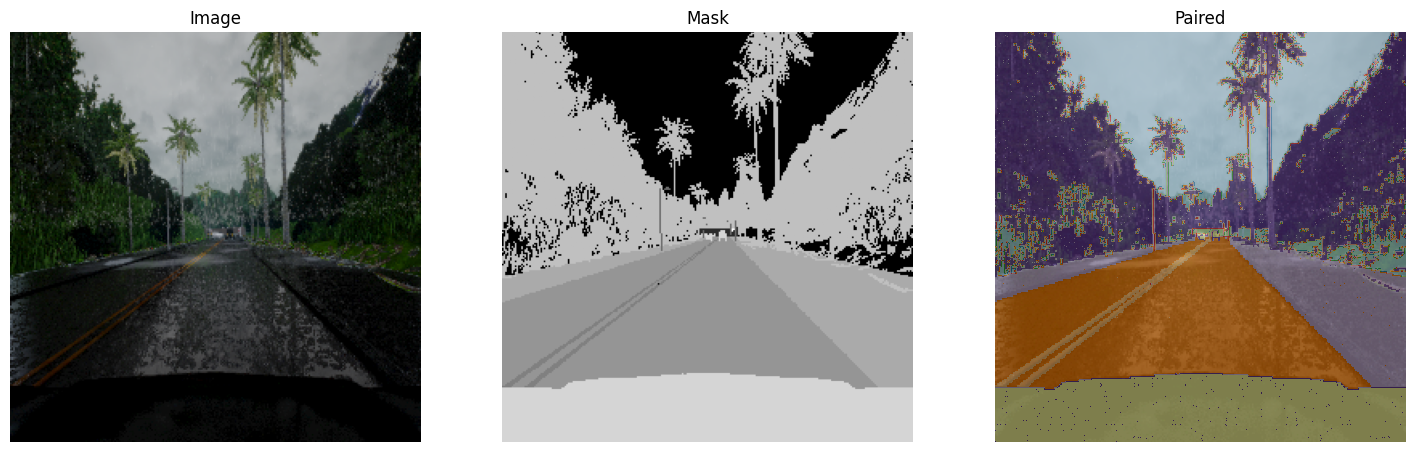

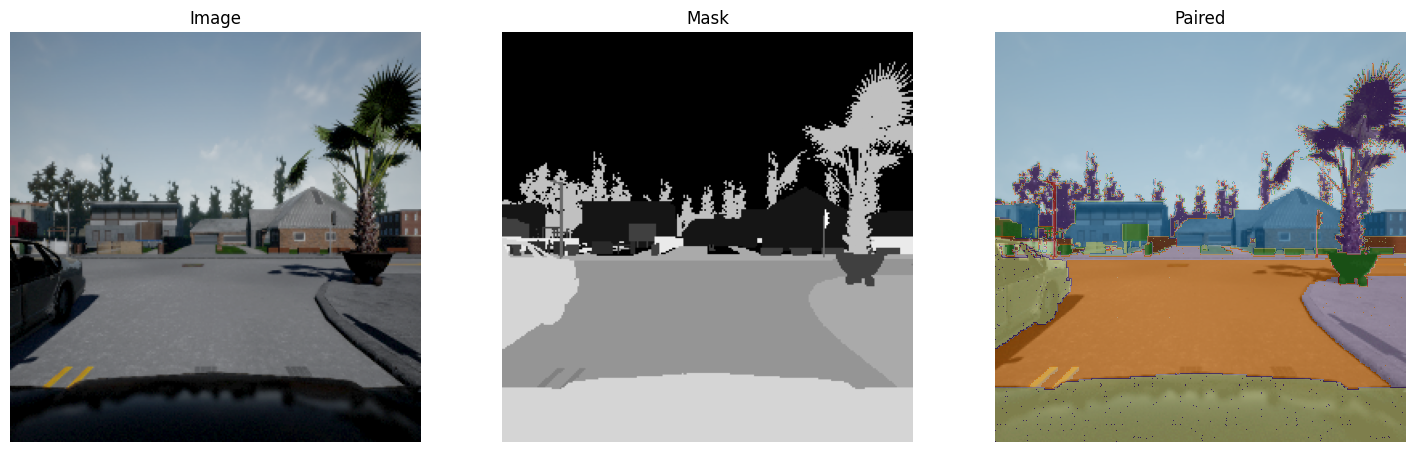

In [30]:
def visualize_images_masks(loader):
    def denormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor

    for img,mask in loader:
        img[0,:,:,:] = denormalize(img[0,:,:,:], mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        img1 = np.transpose(img[0,:,:,:].numpy(),(1,2,0))
        mask1 = np.array(mask[0,:,:])

        fig , ax =  plt.subplots(1, 3, figsize=(18, 12))

        ax[0].imshow(img1)
        ax[0].axis('off')
        ax[0].set_title('Image')

        ax[1].imshow(mask1, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title('Mask')

        # New subplot for paired image
        ax[2].imshow(img1)
        ax[2].imshow(mask1, cmap='Paired', alpha=0.5)
        ax[2].axis('off')
        ax[2].set_title('Paired')

        break


visualize_images_masks(train_loader)
visualize_images_masks(test_loader)


In [6]:
# List class names

labels = ['Unlabeled','Building','Fence','Other',
          'Pedestrian', 'Pole', 'Roadline', 'Road',
          'Sidewalk', 'Vegetation', 'Car','Wall',
          'Traffic sign']

Number of Present Classes: 12
Present Classes: Unlabeled, Building, Fence, Other, Pole, Roadline, Road, Sidewalk, Vegetation, Car, Wall, Traffic sign
Absent Classes: Pedestrian


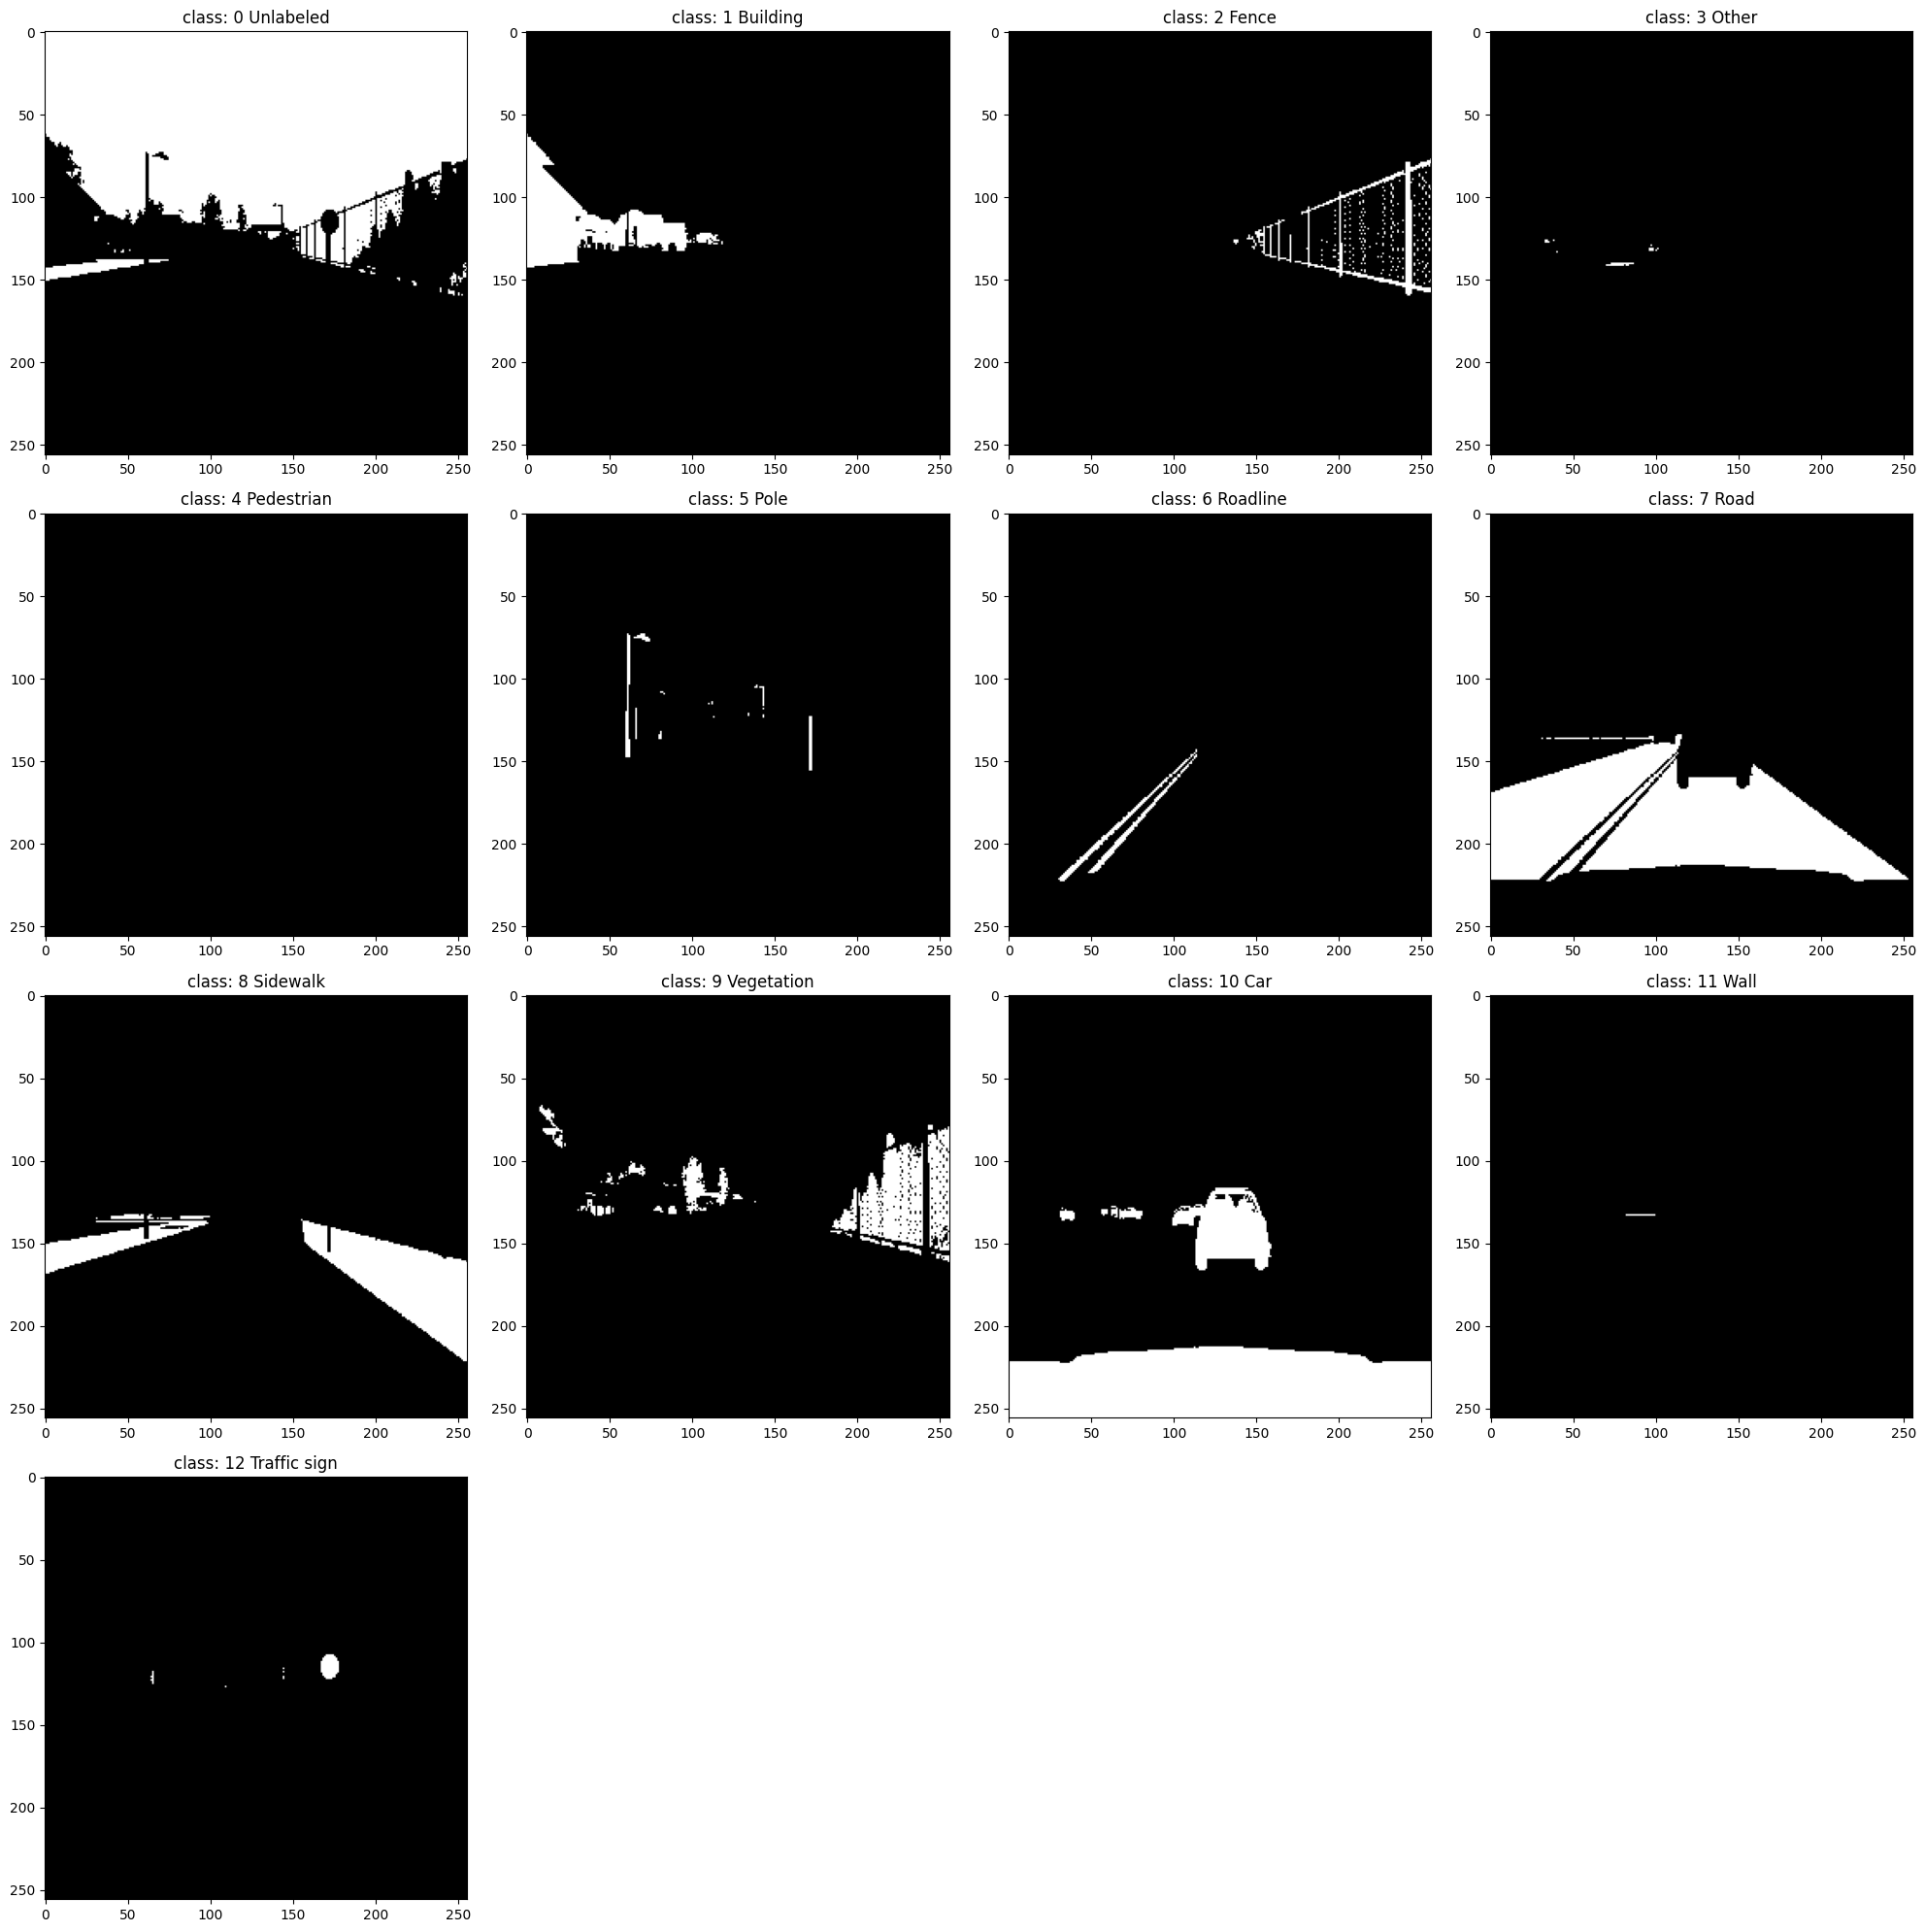

In [8]:
# Visualize the presence of each class in a random image

def plot_class_presence(dataloader, num_classes, labels):
    def get_label_dict(labels):
        return {i: label for i, label in enumerate(labels)}

    label_dict = get_label_dict(labels)

    # Select a random batch
    batch_idx = random.choice(range(len(dataloader)))
    for i, data in enumerate(dataloader):
        if i == batch_idx:
            _, mask = data
            break

    # Convert the mask tensor to numpy
    mask = mask[0].numpy()  # select first instance if it's a batch

    classes_in_image = list(np.unique(mask))

    print(f"Number of Present Classes: {len(classes_in_image)}")
    print(f"Present Classes: {', '.join([label_dict.get(int(c), 'Unlabeled') for c in classes_in_image])}")

    # Find classes not present in image
    missing_classes = set(label_dict.values()) - set([label_dict.get(int(c), 'Unlabeled') for c in classes_in_image])
    print(f"Absent Classes: {', '.join(missing_classes)}")

    # Create subplots
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

    # Flatten axs for easier iterating
    axs = axs.ravel()

    for i in range(num_classes):
        mask_class = np.where(mask == i, 255, 0)

        # Use each subplot separately
        axs[i].set_title(f'class: {i} {labels[i]}')
        axs[i].imshow(mask_class, cmap='gray')

    # Remove any unused subplots
    for j in range(num_classes, len(axs)):
        fig.delaxes(axs[j])

    # Automatically adjust subplot parameters for better layout
    plt.tight_layout()
    plt.show()

plot_class_presence(train_loader, len(labels), labels)

In [29]:
# Count the presence of each class in the dataset to check for class imbalance

def count_class_presence(dataloader, num_classes, labels):
    # Initialize a dictionary to hold the count for each class
    class_count = {label: 0 for label in labels}

    for data in dataloader:
        _, masks = data

        for mask in masks:  # Loop through all items in the batch
            mask = mask.numpy()

            classes_in_image = list(np.unique(mask))

            # Update the count for the present classes
            for c in classes_in_image:
                class_label = labels[int(c)]
                class_count[class_label] += 1

    return class_count

train_class_count = count_class_presence(train_loader, len(labels), labels)
test_class_count = count_class_presence(test_loader, len(labels), labels)

# Create a DataFrame from the dictionaries
df = pd.DataFrame({'Train': train_class_count, 'Test': test_class_count})
df.style


,Train,Test
Unlabeled,4449,551
Building,4009,510
Fence,4239,541
Other,4043,522
Pedestrian,543,108
Pole,4371,546
Roadline,4354,544
Road,4449,551
Sidewalk,4449,551
Vegetation,4449,551


### Model Architecture Building

We've built the model following the U-Net architecture, widely known for its performance in image segmentation tasks. The U-Net model is structured as a symmetric encoding and decoding path where high-level feature representations are combined with low-level ones to achieve precise localization.

##### Model schematic:

<center>
<img src="U-Net - Lyft Self Driving Cars.png">
</center>

##### Key Components of the Model:

1. **Encoding Blocks:** These blocks serve the purpose of extracting and condensing the feature information from the input images. In each block, we have employed two Conv2D layers followed by Batch Normalization and a ReLU activation function. Max-pooling is then applied to reduce the dimensionality, thereby helping us capture the abstract semantic information from the input. Skip connections are set aside for later use in the decoding blocks. 

2. **Decoding Blocks:** In the decoding blocks, we perform up-sampling of the feature maps using Conv2D Transpose (also known as deconvolution) layers. The up-sampled feature map is then concatenated with the corresponding feature map from the encoding path (skip connections), providing high-resolution features. This is followed by two Conv2D layers again followed by Batch Normalization and a ReLU activation function. 

3. **Final Convolution Layer:** At the end of the model, we have a Conv2D layer that maps the features to the desired number of classes. This layer essentially serves the purpose of a per-pixel classifier.

4. **Weights Initialization:** The weights of the Conv2D and Linear layers are initialized using Kaiming He initialization. This method is intended to keep the scale of the gradients roughly the same in all layers, which aids us in effective back-propagation. 

In the construction of our model, the number of filters (or kernels) used in the convolutional layers plays a significant role. It essentially determines the depth of the output volumes, which implies the number of neurons in that layer, thus controlling the model's complexity.

For the encoding path, we started with 64 filters for the first block, and doubled the number of filters in each subsequent block. In the decoding path, we reversed this process, halving the number of filters in each block. This design ensures the model first learns low-level features and then gradually moves to high-level ones, which is a common practice in deep learning. 

As for the kernel size, we set it to 3 for all Conv2D and ConvTranspose2D layers. This means each filter has a width and height of 3 pixels, which is a common choice as it can effectively capture the information of neighboring pixels.

For the activation function, we used ReLU (Rectified Linear Unit), which has been proven effective in various tasks and is computationally efficient. Batch Normalization was applied after each convolution operation to stabilize the learning process and reduce training time.

After constructing the U-Net model, we set it to the appropriate device for GPU powered training.

In [4]:
# Building basic blocks for the U-Net model with skip connections and the Kaiming He initialization

class EncodingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, max_pooling=True):
        super(EncodingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.max_pooling = max_pooling
        if max_pooling:
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip_connection = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)


        skip_connection = x  # Set aside residual

        if self.max_pooling:
            x = self.maxpool(x)
            
        return x, skip_connection
    
class DecodingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecodingBlock, self).__init__()
        
        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)


    def forward(self, x, skip_connection):
        x = self.convT(x)
        x = torch.cat([x, skip_connection], dim=1)  # Concatenate along the channel dimension

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
            
        return x
    
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [7]:
# Build the U-Net model

class UNet(nn.Module):
    def __init__(self, in_channels, filters, n_classes):
        super(UNet, self).__init__()

        # Contracting Path
        self.encode_block1 = EncodingBlock(in_channels, filters, max_pooling=True)
        self.encode_block2 = EncodingBlock(filters, filters * 2, max_pooling=True)
        self.encode_block3 = EncodingBlock(filters * 2, filters * 4, max_pooling=True)
        self.encode_block4 = EncodingBlock(filters * 4, filters * 8, max_pooling=True)
        self.encode_block5 = EncodingBlock(filters * 8, filters * 16, max_pooling=False)

        # Expanding Path
        self.decode_block1 = DecodingBlock(filters * 16, filters * 8)
        self.decode_block2 = DecodingBlock(filters * 8, filters * 4)
        self.decode_block3 = DecodingBlock(filters * 4, filters * 2)
        self.decode_block4 = DecodingBlock(filters * 2, filters)

        self.final_conv = nn.Conv2d(filters, n_classes, kernel_size=1)

    def forward(self, x):

        # Contracting Path
        x, skip1_out = self.encode_block1(x)
        x, skip2_out = self.encode_block2(x)
        x, skip3_out = self.encode_block3(x)
        x, skip4_out = self.encode_block4(x)
        x, _ = self.encode_block5(x)

        # Expanding Path
        x = self.decode_block1(x, skip4_out)
        x = self.decode_block2(x, skip3_out)
        x = self.decode_block3(x, skip2_out)
        x = self.decode_block4(x, skip1_out)
        x = self.final_conv(x)
        
        return x


num_channels = 3
filters = 64
n_classes = 13

model = (
    UNet(in_channels=num_channels, filters=filters, n_classes=n_classes)
    .to(DEVICE)
    .apply(weights_init)
)

summary(model.cuda(), input_size=(num_channels, *IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
     EncodingBlock-8  [[-1, 64, 128, 128], [-1, 64, 256, 256]]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14    

### Model Training

Once the model architecture was set up, the next step was to train the model on our data. The following outlines the major aspects of our training procedure:

##### Hyperparameters and Functions

The training process began with the definition of key training parameters and functions:

- **Learning Rate:** The learning rate was set to 1e-4. This hyperparameter is vital for training as it controls how much to adjust the model's weights with respect the loss gradient. The tests performed with 1e-3 e 1e-5 did not surpass the metrics, indicating that the learning process was better conducted with the selected LR.

- **Number of Epochs:** We trained our model for 30 epochs. Each epoch represents a complete pass through the entire training dataset.

- **Loss Function:** The loss function used was Cross-Entropy Loss. This function is often used for multi-class classification problems, like semantic segmentation, where the task is to assign each pixel a single label from a set of classes.

- **Optimizer:** We used the Adam optimizer, a popular choice due to its efficiency and low memory requirements.

- **Gradient Scaler:** A gradient scaler was used for automatic mixed precision (AMP) training, which can make the training process faster and more memory efficient while maintaining similar accuracy.

- **Learning Rate Scheduler:** The ReduceLROnPlateau learning rate scheduler was employed. This scheduler reduces the learning rate when a metric has stopped improving, which can help to find optimal model parameters.

##### Training Loop

In the training loop, the model performs forward propagation using the input data, calculates the loss, and then performs backpropagation to adjust the model's parameters. The loop iterates over all the batches of data in the training set for each epoch.

The loss values were stored at each iteration, and the average loss was calculated for each epoch.

##### Model Saving and Early Stopping

At the end of each epoch, the model's state was saved if its performance was better (lower loss) than the previous best model.

In addition, an early stopping mechanism was implemented to halt training if the model's performance did not improve for a certain number of consecutive epochs. The patience for early stopping was set to 5 epochs.

##### Learning Rate Adjustment

Lastly, the learning rate scheduler was called at the end of each epoch to possibly decrease the learning rate for the next epoch, based on the average loss of the current epoch. But it haven't activated, since it was using a patience of 3 epochs without improvement.


In [13]:
# Define training parameters

LEARNING_RATE = 1e-4
num_epochs = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)


In [14]:
best_loss = float("inf")
epochs_without_improvement = 0
early_stopping_patience = 5

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    losses = []
    
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Store losses
        losses.append(loss.item())

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    
    # Calculate average loss
    average_loss = np.mean(losses)

    # Check if we need to save the model
    if average_loss < best_loss:
        best_loss = average_loss
        torch.save(model.state_dict(), f"models/best_{START_TIME}.pt")
        print("Best Model Saved!")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # Check for early stopping
    if epochs_without_improvement >= early_stopping_patience:
        print("Early stopping triggered!")
        break

    # Update the learning rate
    lr_scheduler.step(average_loss)

100%|██████████| 557/557 [03:11<00:00,  2.91it/s, loss=0.504]


Best Model Saved!


100%|██████████| 557/557 [02:57<00:00,  3.14it/s, loss=0.171]


Best Model Saved!


100%|██████████| 557/557 [02:57<00:00,  3.15it/s, loss=0.105]


Best Model Saved!


100%|██████████| 557/557 [03:00<00:00,  3.08it/s, loss=0.122] 


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.11it/s, loss=0.299] 


Best Model Saved!


100%|██████████| 557/557 [03:01<00:00,  3.08it/s, loss=0.0931]


Best Model Saved!


100%|██████████| 557/557 [03:01<00:00,  3.07it/s, loss=0.0557]


Best Model Saved!


100%|██████████| 557/557 [03:00<00:00,  3.08it/s, loss=0.101] 


Best Model Saved!


100%|██████████| 557/557 [02:58<00:00,  3.12it/s, loss=0.113] 


Best Model Saved!


100%|██████████| 557/557 [03:00<00:00,  3.08it/s, loss=0.113] 


Best Model Saved!


100%|██████████| 557/557 [03:00<00:00,  3.08it/s, loss=0.0663]


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.10it/s, loss=0.0607]


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.10it/s, loss=0.07]  


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.11it/s, loss=0.0526]


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.11it/s, loss=0.097] 


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.11it/s, loss=0.0407]


Best Model Saved!


100%|██████████| 557/557 [03:03<00:00,  3.03it/s, loss=0.104] 


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.11it/s, loss=0.0466]


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.11it/s, loss=0.0857]


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.10it/s, loss=0.0887]


Best Model Saved!


100%|██████████| 557/557 [02:58<00:00,  3.11it/s, loss=0.0702]


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.09it/s, loss=0.0467]


Best Model Saved!


100%|██████████| 557/557 [02:59<00:00,  3.11it/s, loss=0.038] 


Best Model Saved!


100%|██████████| 557/557 [02:58<00:00,  3.12it/s, loss=0.0363]


Best Model Saved!


100%|██████████| 557/557 [02:58<00:00,  3.12it/s, loss=0.0392]


Best Model Saved!


100%|██████████| 557/557 [02:58<00:00,  3.12it/s, loss=0.0576]


Best Model Saved!


100%|██████████| 557/557 [03:00<00:00,  3.08it/s, loss=0.0459]


Best Model Saved!


### Model Evaluation

The model performance was evaluated using both the training and testing datasets. The best weights from the training process were loaded back into the model for this purpose. The quality of the model's predictions was first visually inspected by comparing a few images from the holdout dataset with their corresponding masks:

<img src="predictions/pred1.png" width="800" height="200">

<img src="predictions/pred4.png" width="800" height="200">

<img src="predictions/pred2.png" width="800" height="200">

<img src="predictions/pred3.png" width="800" height="200">

In addition to this qualitative evaluation, we also computed several metrics to quantify the model's performance. These metrics included Recall, Precision, Intersection over Union (IoU), and F1-Score for each class. Below, we present these results for the training and testing datasets in a combined table:

<center>
<table>
  <tr>
    <th colspan="5">Training Metrics</th>
    <th colspan="5">Test Metrics</th>
  </tr>
  <tr>
    <td>Class</td>
    <td>Recall</td>
    <td>Precision</td>
    <td>IoU</td>
    <td>F1-Score</td>
    <td>Class</td>
    <td>Recall</td>
    <td>Precision</td>
    <td>IoU</td>
    <td>F1-Score</td>
  </tr>
  <tr>
    <td>All Classes</td>
    <td>0.92</td>
    <td>0.95</td>
    <td>0.88</td>
    <td>0.93</td>
    <td>All Classes</td>
    <td>0.88</td>
    <td>0.93</td>
    <td>0.83</td>
    <td>0.90</td>
  </tr>
  <tr>
    <td>Unlabeled</td>
    <td>0.98</td>
    <td>0.99</td>
    <td>0.97</td>
    <td>0.98</td>
    <td>Unlabeled</td>
    <td>0.99</td>
    <td>0.99</td>
    <td>0.98</td>
    <td>0.99</td>
  </tr>
  <tr>
    <td>Building</td>
    <td>0.98</td>
    <td>0.98</td>
    <td>0.97</td>
    <td>0.98</td>
    <td>Building</td>
    <td>0.98</td>
    <td>0.98</td>
    <td>0.96</td>
    <td>0.98</td>
  </tr>
  <tr>
    <td>Fence</td>
    <td>0.76</td>
    <td>0.91</td>
    <td>0.71</td>
    <td>0.83</td>
    <td>Fence</td>
    <td>0.66</td>
    <td>0.82</td>
    <td>0.58</td>
    <td>0.73</td>
  </tr>
  <tr>
    <td>Other</td>
    <td>0.90</td>
    <td>0.93</td>
    <td>0.84</td>
    <td>0.91</td>
    <td>Other</td>
    <td>0.85</td>
    <td>0.91</td>
    <td>0.78</td>
    <td>0.88</td>
  </tr>
  <tr>
    <td>Pedestrian</td>
    <td>0.68</td>
    <td>0.85</td>
    <td>0.61</td>
    <td>0.76</td>
    <td>Pedestrian</td>
    <td>0.55</td>
    <td>0.84</td>
    <td>0.50</td>
    <td>0.66</td>
  </tr>
  <tr>
    <td>Pole</td>
    <td>0.89</td>
    <td>0.93</td>
    <td>0.83</td>
    <td>0.91</td>
    <td>Pole</td>
    <td>0.71</td>
    <td>0.82</td>
    <td>0.61</td>
    <td>0.76</td>
  </tr>
  <tr>
    <td>Roadline</td>
    <td>0.97</td>
    <td>0.96</td>
    <td>0.94</td>
    <td>0.96</td>
    <td>Roadline</td>
    <td>0.97</td>
    <td>0.95</td>
    <td>0.92</td>
    <td>0.96</td>
  </tr>
  <tr>
    <td>Road</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>0.99</td>
    <td>1.0</td>
    <td>Road</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>0.99</td>
    <td>1.0</td>
  </tr>
  <tr>
    <td>Sidewalk</td>
    <td>0.99</td>
    <td>0.98</td>
    <td>0.97</td>
    <td>0.98</td>
    <td>Sidewalk</td>
    <td>0.98</td>
    <td>0.97</td>
    <td>0.95</td>
    <td>0.97</td>
  </tr>
  <tr>
    <td>Vegetation</td>
    <td>0.96</td>
    <td>0.94</td>
    <td>0.91</td>
    <td>0.95</td>
    <td>Vegetation</td>
    <td>0.96</td>
    <td>0.93</td>
    <td>0.89</td>
    <td>0.94</td>
  </tr>
  <tr>
    <td>Car</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>0.99</td>
    <td>1.0</td>
    <td>Car</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>0.99</td>
    <td>1.0</td>
  </tr>
  <tr>
    <td>Wall</td>
    <td>0.96</td>
    <td>0.95</td>
    <td>0.91</td>
    <td>0.95</td>
    <td>Wall</td>
    <td>0.94</td>
    <td>0.90</td>
    <td>0.85</td>
    <td>0.92</td>
  </tr>
  <tr>
    <td>Traffic sign</td>
    <td>0.89</td>
    <td>0.94</td>
    <td>0.84</td>
    <td>0.91</td>
    <td>Traffic sign</td>
    <td>0.80</td>
    <td>0.92</td>
    <td>0.75</td>
    <td>0.86</td>
  </tr>
</table>
</center>

The table provides detailed insights into the model's performance on both datasets. This comprehensive evaluation allows us to not only assess the overall performance but also identify the classes for which the model may be struggling, guiding future improvements.

Analysis of the evaluation metrics table allows us to infer several insights:

1. **Overall Model Performance**: The model generally performed well on both the training and test datasets, as indicated by the high Recall, Precision, IoU, and F1-Score for "All Classes".

2. **Overfitting**: By comparing the training and test results, we can assess the model's generalization abilities. In this case, we see minor changes in performance from training to testing for most classes, suggesting the model generalizes reasonably well.

3. **Class-wise Performance**: Some classes like "Road" and "Building" have very high scores across all metrics, indicating the model is very effective at predicting these classes. On the other hand, classes like "Pedestrian" and "Fence" have relatively lower scores, especially in the test set, indicating these are more challenging classes for the model to predict correctly.

4. **Potential Areas for Improvement**: The comparatively lower performance on certain classes may suggest a need for additional focus in these areas. This could potentially be addressed through techniques such as data augmentation to increase the representation of these classes, fine-tuning of the model with more data from this classes, or incorporating class weighting in the loss function to give more importance to these challenging classes.

5. **Precision and Recall Trade-off**: For some classes, there's a noticeable difference between precision and recall, which is a common trade-off in many models. For instance, 'Pedestrian' class has a higher precision than recall, which indicates that the model is conservative about predicting this class - when it does predict 'Pedestrian', it's often correct, but it also misses a good number of actual 'Pedestrian' instances. On the other hand, for the 'Fence' class, recall is higher than precision in the training dataset, suggesting that the model is more liberal in predicting this class, leading to more False Positives.

6. **Intersection over Union (IoU)**: The IoU scores are generally high for all classes in both training and testing datasets. However, classes like 'Pedestrian', 'Fence', and 'Pole' have lower IoU scores. This means that the model is not as good at correctly localizing these objects within the image compared to other classes.

7. **F1-Score**: F1-score is a balanced metric of precision and recall, and hence is a good measure of overall performance. Here, it is evident that the model performs well for most classes but could use improvements for the 'Pedestrian', 'Fence', and 'Pole' classes.

The previous imbalance in both pixel volume and the number of images with instances of the 'Pedestrian', 'Fence', and 'Pole' classes could be the main cause of weaker performance for these classes. It is recommended to use techniques such as data augmentation to increase the representation of these classes, fine-tune the model with more data from these classes, or incorporate class weighting in the loss function for these challenging classes.



In [222]:
# Load best model weights

model.load_state_dict(
    torch.load(
        f"models/best_{START_TIME}.pt",
        map_location=torch.device(DEVICE),
    )
)

<All keys matched successfully>

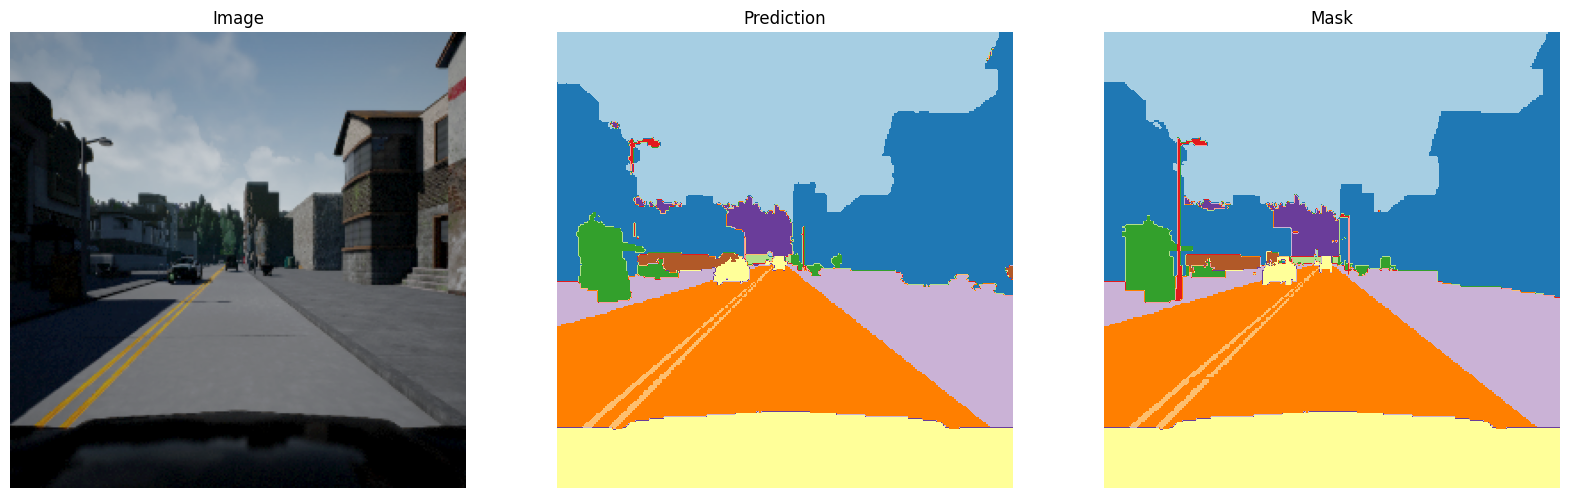

In [221]:
# Visualize the predictions of the model on a random image from the test set

def plot_predictions(dataloader, model, device):
    def denormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor
    for x, y in dataloader:
        x = x.to(device)
        fig , ax =  plt.subplots(1, 3, figsize=(20, 20))
        softmax = nn.Softmax(dim=1)
        preds = torch.argmax(softmax(model(x)), axis=1).to('cpu')

        # denormalize before converting to numpy array
        x[0,:,:,:] = denormalize(x[0,:,:,:], mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        img1 = np.transpose(x[0,:,:,:].to('cpu').numpy(),(1,2,0))
        preds1 = preds[0,:,:].numpy()
        mask1 = y[0,:,:].numpy()

        ax[0].set_title('Image')
        ax[1].set_title('Prediction')
        ax[2].set_title('Mask')

        ax[0].axis("off")
        ax[1].axis("off")
        ax[2].axis("off")

        ax[0].imshow(img1)
        ax[1].imshow(preds1, cmap='Paired')
        ax[2].imshow(mask1, cmap='Paired')

        break

plot_predictions(test_loader, model, DEVICE)

In [18]:
# Evaluate metrics

# The following function is an adaptation of the evaluate_model function from the following kaagle notebook: https://www.kaggle.com/code/oluwatobiojekanmi/carla-image-semantic-segmentation-with-u-net
def evaluate_model(model, dataloader, device, n_classes, criterion, smooth=1e-6):
    model.eval()  # Set the model to evaluation mode
    true_masks, predicted_masks = [], []  # Store true and predicted masks here

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            preds = torch.argmax(outputs, dim=1)

            true_masks.append(labels.cpu().numpy())
            predicted_masks.append(preds.cpu().numpy())

    # Flatten the lists of masks and proceed as before
    true_masks = np.concatenate(true_masks, axis=0)
    predicted_masks = np.concatenate(predicted_masks, axis=0)

    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [], []
    class_wise_false_positives, class_wise_false_negatives = [], []
    class_wise_precisions, class_wise_recalls = [], []
    class_wise_specificities, class_wise_ious = [], []
    class_wise_tdrs, class_wise_f1_scores = [], []
    classes = []

    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0, 0, 0, 0, 0, 0

        number_of_masks = true_masks.shape[0]

        for mask_id in range(number_of_masks):
            true_positive = np.sum(
                np.logical_and(
                    true_masks[mask_id] == clas, predicted_masks[mask_id] == clas
                )
            )
            true_negative = np.sum(
                np.logical_and(
                    true_masks[mask_id] != clas, predicted_masks[mask_id] != clas
                )
            )
            false_positive = np.sum(
                np.logical_and(
                    true_masks[mask_id] != clas, predicted_masks[mask_id] == clas
                )
            )
            false_negative = np.sum(
                np.logical_and(
                    true_masks[mask_id] == clas, predicted_masks[mask_id] != clas
                )
            )

            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives / (true_positives + false_negatives + smooth), 2)
        precision = round(
            true_positives / (true_positives + false_positives + smooth), 2
        )
        specificity = round(
            true_negatives / (true_negatives + false_positives + smooth), 2
        )
        tdr = round(
            (1 - (false_negatives / (true_positives + false_negatives + smooth))), 2
        )
        iou = round(
            true_positives
            / (true_positives + false_negatives + false_positives + smooth),
            2,
        )
        f1_score = round((2 * precision * recall) / (precision + recall + smooth), 2)

        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        classes.append("Class " + str(clas + 1))

    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)

    class_wise_evaluations = {
        "Class": classes,
        "True Positive Pixels": class_wise_true_positives,
        "True Negative Pixels": class_wise_true_negatives,
        "False Positive Pixels": class_wise_false_positives,
        "False Negative Pixels": class_wise_false_negatives,
        "Recall": class_wise_recalls,
        "Precision": class_wise_precisions,
        "Specificity": class_wise_specificities,
        "IoU": class_wise_ious,
        "TDR": class_wise_tdrs,
        "F1-Score": class_wise_f1_scores,
    }

    overall_evaluations = {
        "Class": "All Classes",
        "True Positive Pixels": total_true_positives,
        "True Negative Pixels": total_true_negatives,
        "False Positive Pixels": total_false_positives,
        "False Negative Pixels": total_false_negatives,
        "Recall": mean_recall,
        "Precision": mean_precision,
        "Specificity": mean_specificity,
        "IoU": mean_iou,
        "TDR": mean_tdr,
        "F1-Score": mean_f1_score,
    }

    evaluations = {
        "Overall Evaluations": overall_evaluations,
        "Class-wise Evaluations": class_wise_evaluations,
    }

    return evaluations


def show_evaluations(
    evaluations,
    metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1 Score"],
    class_list=None,
    display_evaluations="All",
):
    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]

    # Validate list of metrics
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError(
                "'metrics argument' not properly defined. "
                "Kindly create a list containing one or more of the following metrics: "
                "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'"
            )

    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError(
                "class_list argument' not properly defined. "
                "List is either shorter or longer than segmentation classes"
            )
    else:
        class_list = [class_wise_evaluations["Class"]]

    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"]] + [
        overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))
    ]
    classwise_data = class_list + [
        class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))
    ]
    overall_data = np.array(overall_data).reshape(1, -1)
    classwise_data = np.array(classwise_data).transpose()

    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError(
            "Display argument are not properly defined."
            "Kindly use 'All' to display both overall and class-wise evaluations."
            "Use 'Overall' to display only the overall evaluations."
            "Or use 'Class-wise' to display only the class-wise evaluations"
        )

    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class"] + metrics
    dataframe.columns = dataframe_titles

    return dataframe

In [21]:
# Verify the model performance on the train set

evaluations = evaluate_model(model, train_loader, DEVICE, n_classes, loss_fn)

show_evaluations(
    evaluations,
    metrics=["Recall", "Precision", "IoU", "F1-Score"],
    class_list=labels,
    display_evaluations="All",
)

,Class,Recall,Precision,IoU,F1-Score
0,All Classes,0.92,0.95,0.88,0.93
1,Unlabeled,0.98,0.99,0.97,0.98
2,Building,0.98,0.98,0.97,0.98
3,Fence,0.76,0.91,0.71,0.83
4,Other,0.9,0.93,0.84,0.91
5,Pedestrian,0.68,0.85,0.61,0.76
6,Pole,0.89,0.93,0.83,0.91
7,Roadline,0.97,0.96,0.94,0.96
8,Road,1.0,1.0,0.99,1.0
9,Sidewalk,0.99,0.98,0.97,0.98


In [19]:
# Verify the model performance on the test set

evaluations = evaluate_model(model, test_loader, DEVICE, n_classes, loss_fn)

show_evaluations(
    evaluations,
    metrics=["Recall", "Precision", "IoU", "F1-Score"],
    class_list=labels,
    display_evaluations="All",
)

,Class,Recall,Precision,IoU,F1-Score
0,All Classes,0.88,0.93,0.83,0.9
1,Unlabeled,0.99,0.99,0.98,0.99
2,Building,0.98,0.98,0.96,0.98
3,Fence,0.66,0.82,0.58,0.73
4,Other,0.85,0.91,0.78,0.88
5,Pedestrian,0.55,0.84,0.5,0.66
6,Pole,0.71,0.82,0.61,0.76
7,Roadline,0.97,0.95,0.92,0.96
8,Road,1.0,1.0,0.99,1.0
9,Sidewalk,0.98,0.97,0.95,0.97
